# Ensembles
## Carga de datos

In [1]:
# Importamos librerías esenciales para análisis de datos
import pandas as pd  # Para manipulación de datos estructurados
import numpy as np   # Para operaciones numéricas
import matplotlib as mpl  # Para configuración de gráficos
import seaborn as sns     # Para visualizaciones estadísticas

# Cargamos el dataset de Titanic modificado para clasificación
df = pd.read_csv('data/titanic_modified.csv')
# Mostramos información básica del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   MissingAge  891 non-null    int64  
 7   Spouse      891 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 55.8 KB


In [2]:
# Importamos train_test_split para dividir los datos
from sklearn.model_selection import train_test_split

# Obtenemos los nombres de las columnas que usaremos como características
classes = list(df.loc[:, 'Pclass':].columns)

# Separamos características (X) y variable objetivo (y)
X = df.loc[:, 'Pclass':].values  # Todas las columnas desde 'Pclass' hasta el final
y = df['Survived'].values        # Variable objetivo: supervivencia

# Dividimos los datos en conjuntos de entrenamiento y prueba
# test_size=0.20: 20% para prueba, 80% para entrenamiento
# random_state=55: semilla para reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state=55)

## Voting classifier
1. Primero declaramos todos los clasificadores que participarán en el voting classifier.
2. A continuación agrupamos los estimadores en una lista de tuplas, con sus identificadores.
3. Declaramos el VotingClassifier

En primer lugar, probaremos un `hard` VotingClassifier, es decir, tendrá en cuenta las predicciones de los clasificadores, no sus probabilidades.

In [3]:
# Probamos la generación de números aleatorios con semilla
# Esto demuestra la reproducibilidad cuando fijamos random_state
np.random.seed(42)
print(np.random.randint(10))  # Primer número aleatorio
print(np.random.randint(10))  # Segundo número aleatorio

6
3


In [4]:
# Importamos los algoritmos necesarios para crear el ensemble de votación
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

'''
Creamos tres clasificadores diferentes para el ensemble:
1. LogisticRegression: algoritmo lineal rápido y interpretable
2. RandomForestClassifier: ensemble de árboles, robusto y eficaz
3. SVC: Support Vector Classifier, potente para clasificación no-lineal

Nota: Por defecto VotingClassifier usa 'soft' voting si todos los algoritmos
soportan predict_proba(). SVM requiere probability=True para esto.
'''

# Configuramos los tres clasificadores base
log_clf = LogisticRegression(random_state=42) # Regresión logística
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42) # Random Forest con 100 árboles
svm_clf = SVC(gamma="scale", random_state=42)  # SVM con parámetros por defecto

# Creamos una lista de tuplas con identificador y modelo
estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)]

# Creamos el VotingClassifier con votación 'hard' (por mayoría simple)
voting_clf = VotingClassifier(estimators=estimators, voting='hard')

In [5]:
# Entrenamos el VotingClassifier con votación hard (por mayoría simple)
# Cada algoritmo vota por una clase y se elige la clase más votada
voting_clf.fit(X_train, y_train)

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


Vemos los aciertos (accuracy score) de todos los clasificadores + el voting classifier

In [6]:
# Importamos accuracy_score para evaluar el rendimiento
from sklearn.metrics import accuracy_score

# Comparamos el rendimiento individual de cada clasificador vs el ensemble
# Entrenamos y evaluamos cada modelo por separado
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    # Entrenamos el modelo actual
    clf.fit(X_train, y_train)
    # Hacemos predicciones en el conjunto de test
    y_pred = clf.predict(X_test)
    # Mostramos el nombre del algoritmo y su accuracy
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7988826815642458
RandomForestClassifier 0.7932960893854749
SVC 0.6145251396648045
VotingClassifier 0.8044692737430168


Probaremos ahora con el `soft` VotingClassifier, es decir, teniendo e cuenta las probabilidades, no los votos.

In [7]:
# Configuramos los clasificadores para votación 'soft' (basada en probabilidades)
# En soft voting, se promedian las probabilidades de cada clase para la decisión final
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42) # probability=True necesario para soft voting

estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)]

# Creamos VotingClassifier con votación 'soft' (promedia probabilidades)
soft_voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Entrenamos el modelo
soft_voting_clf.fit(X_train, y_train)

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [8]:
# Comparamos el rendimiento de cada algoritmo individual vs el ensemble con soft voting
# El soft voting suele ser superior al hard voting cuando los algoritmos estiman bien las probabilidades
for clf in (log_clf, rnd_clf, svm_clf, soft_voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7988826815642458
RandomForestClassifier 0.7932960893854749
SVC 0.6145251396648045
VotingClassifier 0.8044692737430168


## Bagging Classifier
Sistema de clasificación por votación de algoritmos. En este caso siempre es el mismo tipo de algoritmo, habitualmente árboles de decisión.

El siguiente ejemplo sería un algoritmo muy similar a un RandomForest.

In [9]:
# Implementamos un BaggingClassifier (Bootstrap Aggregating)
# Este es la base del RandomForest: múltiples modelos del mismo tipo con muestreo aleatorio
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Definimos el estimador base: un árbol de decisión con profundidad máxima 3
estimator = DecisionTreeClassifier(max_depth=3, random_state=42)

# Configuramos el BaggingClassifier
bag_clf = BaggingClassifier(
    estimator = estimator,        # Tipo de modelo base
    n_estimators=300,             # Número de modelos en el ensemble
    max_samples=100,              # Cantidad de muestras para cada modelo (bootstrap)
    bootstrap=True,               # Usamos bootstrap (muestreo con reemplazo)
    # max_features = 3            # Features aleatorias por modelo (comentado)
    random_state=42)

# Entrenamos el ensemble
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8100558659217877

Mejor que un DecisionTree por separado

In [10]:
# Comparamos el rendimiento del BaggingClassifier con un árbol individual
# Esto demuestra el poder del ensemble: reduce la varianza y mejora la generalización
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.770949720670391


## Random Forest

Los RandomForest cuentan con todos los hiperparámetros de un DecissionTree y los de un algoritmo de Bagging.

**RandomForestClassifier**

In [11]:
# Implementamos RandomForestClassifier
# Es una versión optimizada de BaggingClassifier que añade aleatoriedad en las características
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500,    # 500 árboles en el bosque
                                 max_leaf_nodes=16,   # Máximo 16 nodos hoja por árbol
                                 random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
# Calculamos la precisión del Random Forest
accuracy_score(y_pred_rf, y_test)

0.8100558659217877

Mejor que el Bagging Classifier, al llevar parámetros por defecto aplicados al DecisionTree que funcionan mejor para estos datos.

Veamos el feature importance. En cada split de los árboles se calcula el IG (Information Gained) teniendo en cuenta la entropía antes y después del split. Se realiza una ponderación del IG en cada spllit, teniendo en cuenta la feature del split y con ello sklearn consigue el feature importance

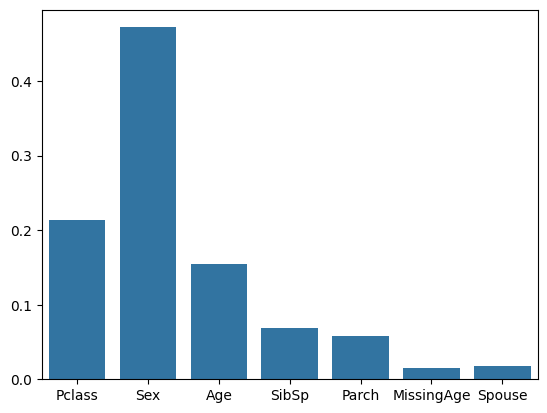

In [12]:
# Visualizamos la importancia de las características según el Random Forest
# El feature importance se calcula basado en cuánto reduce cada característica la impureza
sns.barplot(x=classes, y=rnd_clf.feature_importances_);

**¿Qué hiperparámetros debería tocar en el RandomForest?**
1. `n_estimators`: número de árboles que participarán en las votaciones. Cuantos más mejor. NO producen overfitting. Cuanto más complejo es el dataset, mejor vendrá que haya muchos árboles. Más de 200 suele ser redundante.
2. `max_depth`: profundida de los árboles. Cuanto más profundos, más complejo es el modelo, pero menos generaliza. De  nuevo, cuanto más complejo es el problema, mayor profundidad necesitaremos. No más de 20/30 es lo normal.
3. `max_features`: features a tener en cuenta en los splits del árbol. Cuanto más bajo, mejor generalizará y menos overfitting. Numero menor a la cantidad de features del dataset, sino dará error.
4. `min_samples_split`: mínima cantidad de muestras en un nodo antes de ser spliteado. 2 por defecto. Números bajos suelen dar buenos resultados (<50). Cuanto más alto, mejor generaliza, pero más baja la precisión.
5. `min_samples_leaf`: mínima cantidad de puntos permitidos en un `leaf node`, es decir, un nodo que no va a volver a ser spliteado. Valores bajos funcionan bien (<50).


**RandomForestRegressor**

In [13]:
# Aplicamos RandomForestRegressor para un problema de regresión
# Cargamos dataset de precios de casas en Estados Unidos
df_reg = pd.read_csv('data/USA_Housing.csv')

# Seleccionamos las características (variables independientes)
X_reg = df_reg.loc[:, 'Avg. Area Income': 'Area Population'].values
Y_reg = df_reg['Price'].values  # Variable objetivo: precio de la casa
df_reg.head(2)

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."


In [14]:
# Configuramos y entrenamos RandomForestRegressor
# Para regresión, cada árbol predice un valor numérico y se promedia la predicción
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

rnd_reg = RandomForestRegressor(n_estimators=200,      # 200 árboles
                                max_leaf_nodes=32,     # Máximo 32 nodos hoja
                                random_state=42)
rnd_reg.fit(X_reg, Y_reg)

# Evaluamos con Mean Absolute Error (diferencia promedio entre predicción y valor real)
y_pred_reg = rnd_reg.predict(X_reg)
mean_absolute_error(Y_reg, y_pred_reg)

122084.86984303164

## AdaBoost

**AdaBoostClassifier**

In [15]:
# Implementamos AdaBoostClassifier (Adaptive Boosting)
# AdaBoost entrena modelos secuencialmente, cada uno corrigiendo los errores del anterior
from sklearn.ensemble import AdaBoostClassifier

# Usamos árboles de decisión muy simples (stumps) como estimadores base
estimator = DecisionTreeClassifier(max_depth=1)  # max_depth=1 = decision stump

ada_clf = AdaBoostClassifier(estimator = estimator,
                             n_estimators=200,      # 200 iteraciones
                             learning_rate=0.5,     # Tasa de aprendizaje (contribución de cada modelo)
                             random_state=42)

ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8044692737430168

También tenemos feature importance

In [17]:
# Mostramos las importancias de características calculadas por AdaBoost
# Estas se basan en cómo cada característica contribuye a reducir el error
ada_clf.feature_importances_

array([0.14081438, 0.18511056, 0.20886658, 0.23593856, 0.22926992,
       0.        , 0.        ])

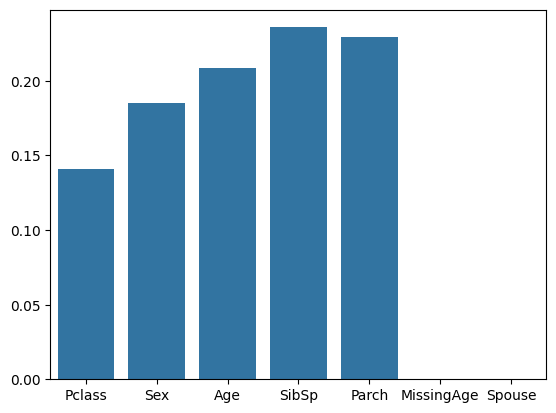

In [18]:
# Visualizamos la importancia de características del AdaBoost
# Comparamos con RandomForest para ver diferencias en la selección de características
sns.barplot(x=classes, y=ada_clf.feature_importances_);

**¿Qué hiperparámetros debería tocar en el AdaBoostClassifier?**
1. `n_estimators`: número de árboles que participarán en la corrección secuencial del error del modelo. Si corregimos el error a la perfección el algoritmo termina de entrenar. Cuantos más estimadores, mejor corregiremos el error pero mayor probabilidad de caer en overfitting. Valores superiores a 100 suelen sobreajustar el modelo aunque dependerá de la complejidad y volumen de los datos.
2. `learning_rate`: no suele tener valores superiores a 1. Cuanto más alto, más aporta cada nuevo árbol, más preciso, pero caemos en overfitting. **Importante**: un learning rate bajo y alto número de estimadores no necesariamente tiene por qué aumentar la precisión y si va a inducir en altos costes computacionales.
3. `algorithm`: 'SAME' o 'SAME.R'. 'SAME.R' utiliza la probabilidad para actualizar los modelos aditivos, mientras que 'SAME' usa los valores de clasificación. Similar a soft vs hard voting. 'SAMME.R' converge antes que 'SAMME'
4. `estimator`: se suele dejar por defecto, aunque podría encajar un SVM o una RegresiónLogística
5. `max_depth`: **OJO**, no es un hiperparámetro del AdaBoostClassifier, sino del DecisionTreeClassifier. Habrá que probar varios árboles con diferentes `max_depth` y después ponerlos como `base_estimator` en el AdaBoost. Cuanto mayor es este hiperparámetro, más preciso, pero también más overfitting.

**AdaBoostRegressor**

In [19]:
# Implementamos AdaBoostRegressor para problemas de regresión
# Funciona igual que el clasificador pero para valores continuos
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(n_estimators=200,    # 200 estimadores
                            random_state=42)
ada_reg.fit(X_reg, Y_reg)

# Evaluamos el rendimiento con Mean Absolute Error
y_pred_ada_reg = ada_reg.predict(X_reg)
mean_absolute_error(Y_reg, y_pred_ada_reg)

100809.79130779192

## GradientBoosting

**GradientBoostingRegressor**

El GradientBoosting funciona sólo con árboles, por eso no es posible cambiar el estimador. Directamente los hiperparámetros a configurar en en GradientBoosting son los del DecissionTree.

En este caso, vamos a probar primero con un regresor, que se entiende mejor.

In [20]:
# Demostramos Gradient Boosting manualmente paso a paso
# Creamos datos sintéticos para entender mejor el proceso
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5  # 100 puntos entre -0.5 y 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)  # Función cuadrática + ruido

In [21]:
# Paso 1: Entrenamos el primer árbol con los datos originales
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [22]:
# Paso 2: Calculamos los residuos (errores) y entrenamos el segundo árbol
y2 = y - tree_reg1.predict(X)  # Residuos = valores reales - predicciones del árbol 1
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)  # Entrenamos el segundo árbol para predecir los residuos

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [23]:
# Paso 3: Calculamos los residuos del segundo paso y entrenamos el tercer árbol
y3 = y2 - tree_reg2.predict(X)  # Nuevos residuos = residuos anteriores - predicciones árbol 2
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)  # El tercer árbol intenta capturar lo que queda por explicar

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [24]:
# Definimos un punto nuevo para hacer predicción
X_new = np.array([[0.8]])

In [25]:
# Predicción final del ensemble: suma de todas las predicciones
# GradientBoosting = árbol1 + árbol2 + árbol3 + ... (cada uno corrige errores del anterior)
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [26]:
# Mostramos el resultado de la predicción del ensemble manual
y_pred

array([0.75026781])

In [27]:
# Importamos matplotlib para visualización
import matplotlib.pyplot as plt

In [28]:
# Función auxiliar para visualizar las predicciones de los regresores
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    """
    Visualiza las predicciones de uno o varios regresores
    """
    x1 = np.linspace(axes[0], axes[1], 500)  # Puntos para graficar la curva
    # Suma las predicciones de todos los regresores (para ensemble)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)    # Datos originales
    plt.plot(x1, y_pred, style, linewidth=2, label=label) # Predicciones del modelo
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

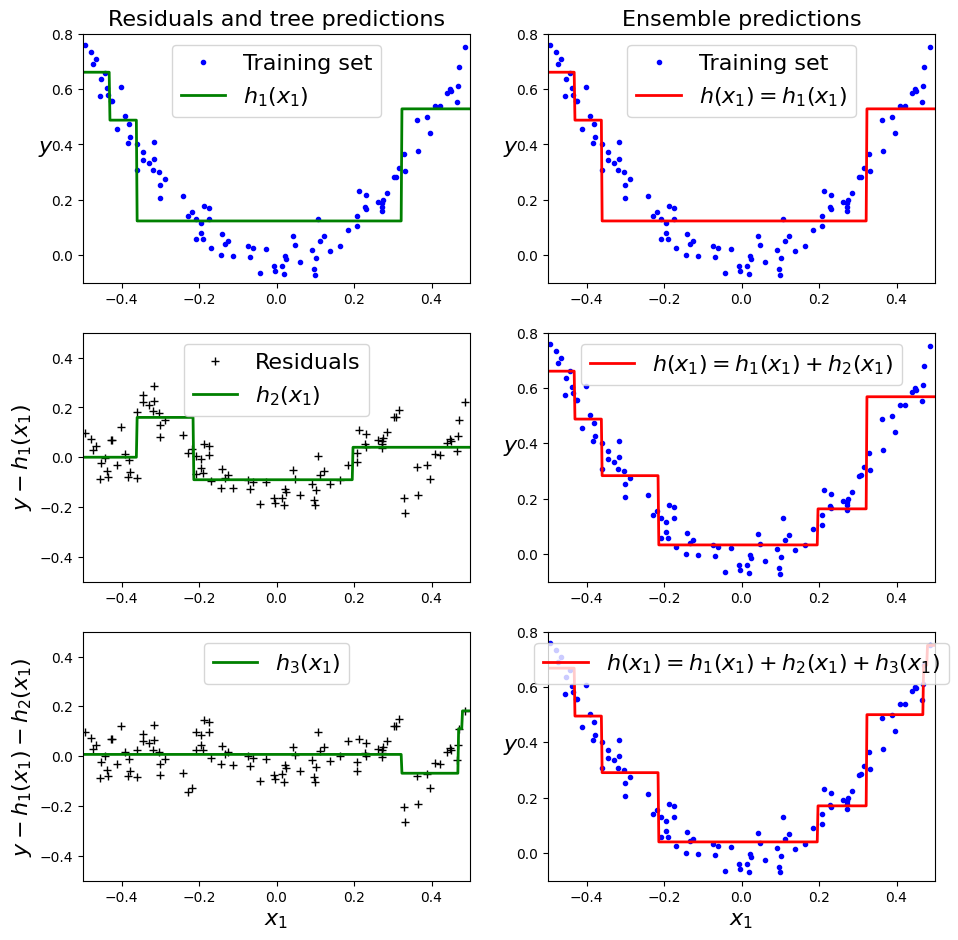

In [29]:
# Visualizamos paso a paso el proceso de Gradient Boosting
# Mostramos cómo cada árbol mejora la predicción del anterior
plt.figure(figsize=(11,11))

plt.subplot(321)
# Primer árbol: predicción inicial
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
# Ensemble con solo el primer árbol
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
# Segundo árbol: entrena en los residuos del primero
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
# Ensemble con primer + segundo árbol
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
# Tercer árbol: entrena en los residuos restantes
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
# Ensemble final: suma de los tres árboles
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [30]:
# Implementamos GradientBoostingRegressor usando sklearn
# Esto automatiza el proceso manual que acabamos de ver
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,         # Profundidad máxima de cada árbol
                                 n_estimators=100,    # 100 iteraciones (árboles)
                                 learning_rate=1.0,   # Tasa de aprendizaje (contribución de cada árbol)
                                 random_state=42)
gbrt.fit(X_reg, Y_reg)

# Evaluamos el rendimiento
y_pred_gbrt = gbrt.predict(X_reg)
mean_absolute_error(Y_reg, y_pred_gbrt)

77190.73094110053

**GradientBoostingClassifier**

In [31]:
# Implementamos GradientBoostingClassifier para problemas de clasificación
# Funciona similar al regresor pero con función de pérdida para clasificación
from sklearn.ensemble import GradientBoostingClassifier

gbct = GradientBoostingClassifier(max_depth=2,         # Profundidad máxima de cada árbol
                                 n_estimators=100,     # 100 iteraciones
                                 learning_rate=1.0,    # Tasa de aprendizaje
                                 random_state=42)
gbct.fit(X_train, y_train)

# Evaluamos con accuracy
y_pred_gbct = gbct.predict(X_test)
accuracy_score(y_test, y_pred_gbct)

0.8100558659217877

**¿Qué hiperparámetros debería tocar en el GradientBoosting?**
1. `n_estimators`: número de árboles que participarán en la corrección secuencial del error del modelo. Si corregimos el error a la perfección el algoritmo termina de entrenar. Cuantos más estimadores, mejor corregiremos el error pero mayor probabilidad de caer en overfitting. Valores superiores a 100 suelen sobreajustar el modelo aunque dependerá de la complejidad y volumen de los datos.
2. `learning_rate`: no suele tener valores superiores a 1. Cuanto más alto, más aporta cada nuevo árbol, más preciso, pero caemos en overfitting. **Importante**: un learning rate bajo y alto número de estimadores no necesariamente tiene por qué aumentar la precisión y si va a inducir en altos costes computacionales.
3. `max_depth`: Cuanto mayor es este hyperparámetro, más preciso, pero también más overfitting.

Se puede iterar sobre todos los hiperparámetros recorridos en el RandomForest

## XGBoost

**XGBRegressor**

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

XGBoost permite regularizar el modelo, puede manejar missings, por lo que no es necesario tener el dataset perfectamente limpio

In [ ]:
# Líneas para instalar las librerías necesarias (ejecutar si no están instaladas)
#!pip install xgboost
#!pip install lightgbm

In [32]:
# Implementamos XGBoostRegressor - versión optimizada de Gradient Boosting
# XGBoost incluye regularización, manejo de valores faltantes y mejor rendimiento
import xgboost

# Creamos y entrenamos el regresor XGBoost con parámetros por defecto
xgb_reg = xgboost.XGBRegressor(random_state=42)

xgb_reg.fit(X_reg, Y_reg)
y_pred = xgb_reg.predict(X_reg)
# Evaluamos: XGBoost suele dar mejor rendimiento que sklearn GradientBoosting
mean_absolute_error(Y_reg, y_pred) 

40058.16122527126

In [33]:
# Implementamos XGBoostClassifier para problemas de clasificación
# Mantiene las ventajas del regresor: regularización, eficiencia y robustez
xgb_clas = xgboost.XGBClassifier(random_state=42)

xgb_clas.fit(X_train, y_train)
y_pred = xgb_clas.predict(X_test)
# XGBoost suele superar a otros algoritmos de boosting en muchos datasets
accuracy_score(y_test, y_pred)

0.8100558659217877

**¿Qué hiperparámetros debería tocar en el XGB?**
1. `n_estimators`: igual que para el GradientBoosting.
2. `booster`: tipo de modelo que correrá en cada iteración. Arboles o regresiones. `gbtree` or `gblinear`. Los árboles suelen ir bien.
3. `learning_rate`: o también llamado `eta`. Como el learning rate del GradientBoosting.
4. `max_depth`: nada nuevo

Si quieres afinar más todavía el XGBoost consulta [esta completa guía](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

## LightGBM

https://lightgbm.readthedocs.io/en/v3.3.2/